# Laptop Price Prediction 

Predicting the price of a laptop given certain features about the product like RAM, GPU, weight etc 

Goal is the find approximate price range of a laptop which may be listed in ecommerce websites like Amazon, Flipkart etc..

In [120]:
# importing all basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



# other required ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import tree

In [121]:
df = pd.read_csv('laptop_data.csv', index_col=0)
df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu   Ram               Memory  \
0        Intel Core i5 2.3GHz   8GB            128GB SSD   
1        Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3        Intel Core i7 2.7GHz  16GB            512GB SSD   
4        Intel Core i5 3.1GHz   8GB            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS  1.37kg   71378.6832  
1        Intel HD Graphics 6000  macOS  1.34kg   47895.5232  
2         Intel HD Graphics 620  No OS  1.86kg   30636.0000  
3            AMD Radeon Pro 455  macOS  1.83kg  135195.3360  
4  Intel Iris Plus Graphics 650  macOS  1.37kg   96095.8080

## Exploratory Data Analysis and Feature Engineering

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


The data contains 

* 1303 records
* Two numeric columns and 8 string based columns 

In [123]:
# checking missing values 

df.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

> There are no missing values in the dataset

In [124]:
# checking duplicated records 

df.duplicated().sum()

29

In [125]:
# Separating categorical and numerical features

cat_vars = df.select_dtypes(include=['object']).columns
num_vars = df.select_dtypes(exclude=['object']).columns

print(cat_vars)
print(num_vars)

Index(['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory',
       'Gpu', 'OpSys', 'Weight'],
      dtype='object')
Index(['Inches', 'Price'], dtype='object')


In [126]:
# fetching unique values in columns

def unique_values(col):
    print(f"The unique values in '{col}' are: {df[col].unique()}")
    
for col in df.columns:
    unique_values(col)
    print("-"*100)

The unique values in 'Company' are: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
----------------------------------------------------------------------------------------------------
The unique values in 'TypeName' are: ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
----------------------------------------------------------------------------------------------------
The unique values in 'Inches' are: [13.3 15.6 15.4 14.  12.  11.6 17.3 10.1 13.5 12.5 13.  18.4 13.9 12.3
 17.  15.  14.1 11.3]
----------------------------------------------------------------------------------------------------
The unique values in 'ScreenResolution' are: ['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / To

**Inference from above result:**
    
Most of columns have quite lot of textual data in it which required good amount of preprocessing to acquire best results.

In [127]:
"""
cleaning the text data as below 
Replacing the 'GB' with empty string so we can treat it as integer value in RAM and Memory feature
Also, in Weight column, removing Kg will help us to treat it as float value
"""

df['Ram'] = df['Ram'].str.replace('GB','').astype('int32')
df['Weight'] = df['Weight'].str.replace('kg','').astype('float32')

df.head()


Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832  
1        Intel HD Graphics 6000  macOS    1.34   47895.5232  
2         Intel HD Graphics 620  No OS    1.86   30636.0000  
3            AMD Radeon Pro 455  macOS    1.83  135195.3360  
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   int32  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   float32
 10  Price             1303 non-null   float64
dtypes: float32(1), float64(2), int32(1), object(7)
memory usage: 112.0+ KB


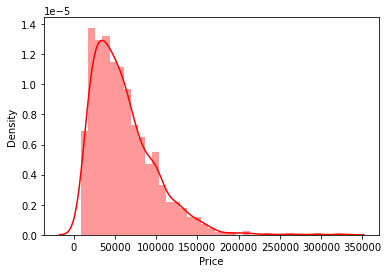

In [129]:
# Distribution of target variable 

sns.distplot(df['Price'], color='red');

In [130]:
df['Price'].describe()

count      1303.000000
mean      59870.042910
std       37243.201786
min        9270.720000
25%       31914.720000
50%       52054.560000
75%       79274.246400
max      324954.720000
Name: Price, dtype: float64

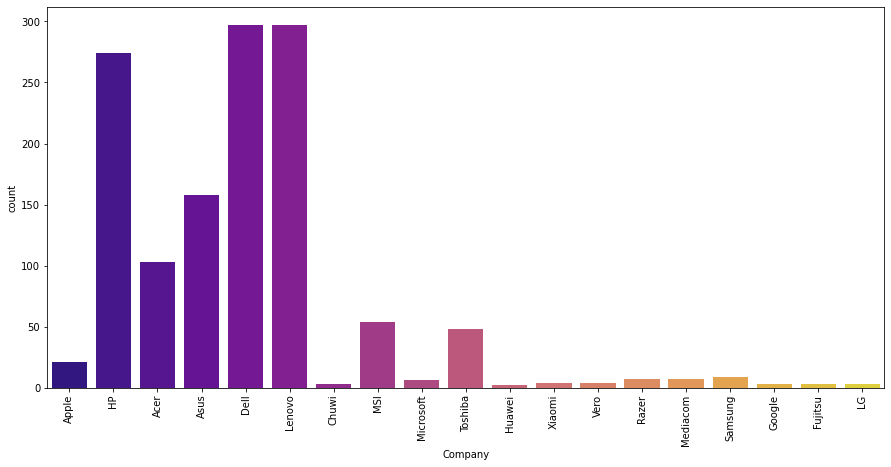

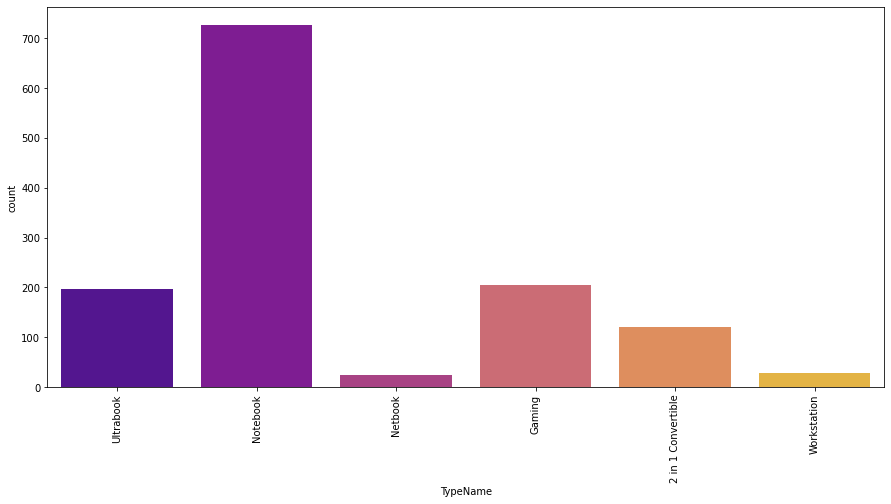

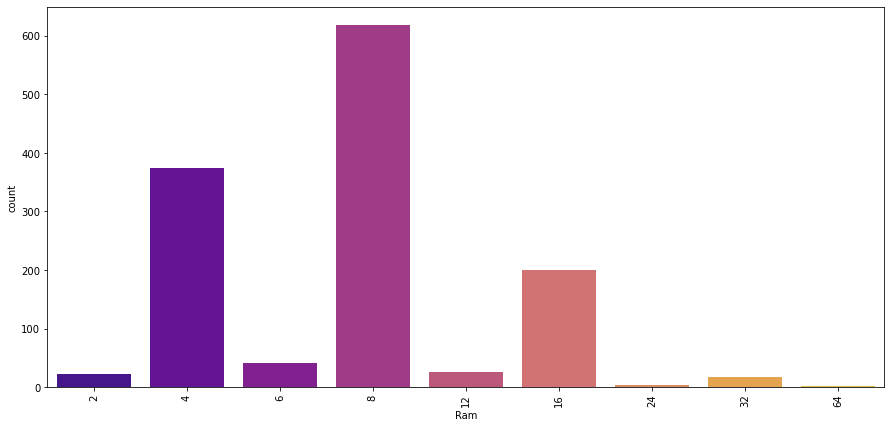

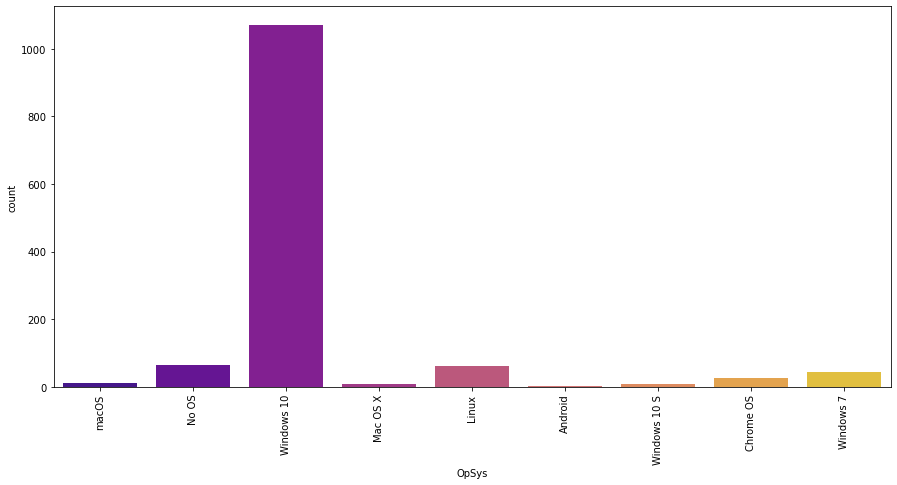

In [131]:
# plotting count plots of categorical variables 

def draw_count_plot(col):
    plt.figure(figsize=(15,7))
    sns.countplot(df[col], palette='plasma')
    plt.xticks(rotation='vertical') # xlabels to be vertical
    
to_view = ['Company', 'TypeName', 'Ram', 'OpSys']

for col in to_view:
    draw_count_plot(col)

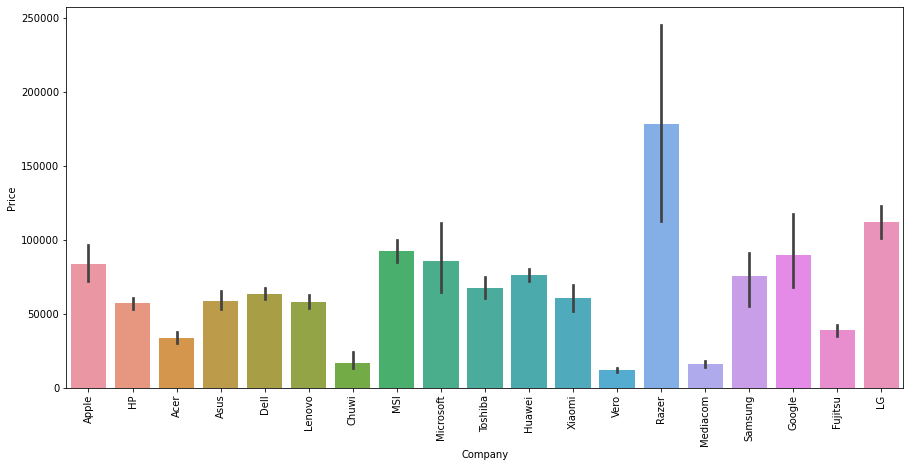

In [132]:
# Average price of the laptop based on brand 

plt.figure(figsize=(15,7))
sns.barplot(x='Company', y='Price', data=df, ci=95) # black lines indicates 95% CI
plt.xticks(rotation='vertical')
plt.show()

In [133]:
df['TypeName'].value_counts()

Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: TypeName, dtype: int64

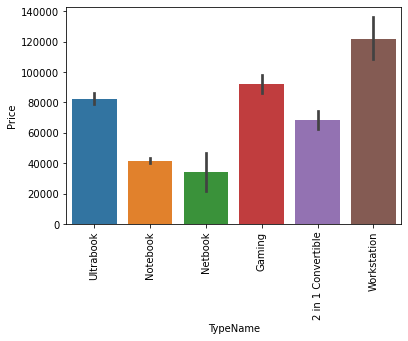

In [134]:
# laptop type and variation in price

sns.barplot(x='TypeName', y='Price', data=df, ci=95) # black lines indicates 95% CI
plt.xticks(rotation='vertical')
plt.show()

> The variation in notebook is smaller because it is most widely used by any customer in World, so the variation in price 
is lesser comapred to others 

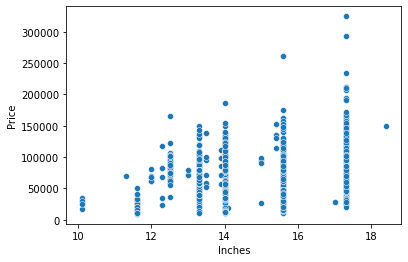

In [135]:
# comaprison of inches with Price 

sns.scatterplot('Inches', 'Price', data=df);

From above graph, we can infer that 

* 17 inches laptop has higher price laptop than others
* Most of users buy laptop with inches between 12 and 15, where most of data are accummulated 
* The cheaper laptops are smaller in size

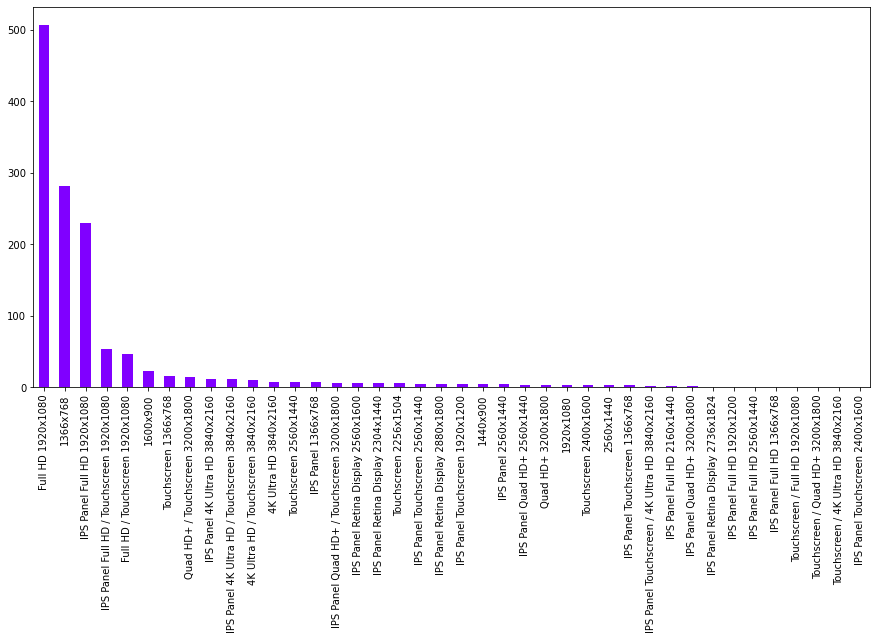

In [136]:
# checking the different types of screen resolution types

plt.figure(figsize=(15,7))
df['ScreenResolution'].value_counts().plot(kind='bar', cmap='rainbow')
plt.show()

In [137]:
df['ScreenResolution'].value_counts()

Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440               

> We could observe that there are lot of screen resolution types which have touch screen or IPS panel in it, so better creating a new variables like touch screen, IPS panel etc.. to break this feature into new features. 

In [138]:
# creating new variable called touch screen with values 1 and 0

df['TouchScreen'] = df['ScreenResolution'].apply(lambda ele :1 if 'Touchscreen' in ele else 0)

df

Company            TypeName  Inches  \
0         Apple           Ultrabook    13.3   
1         Apple           Ultrabook    13.3   
2            HP            Notebook    15.6   
3         Apple           Ultrabook    15.4   
4         Apple           Ultrabook    13.3   
5          Acer            Notebook    15.6   
6         Apple           Ultrabook    15.4   
7         Apple           Ultrabook    13.3   
8          Asus           Ultrabook    14.0   
9          Acer           Ultrabook    14.0   
10           HP            Notebook    15.6   
11           HP            Notebook    15.6   
12        Apple           Ultrabook    15.4   
13         Dell            Notebook    15.6   
14        Apple           Ultrabook    12.0   
15        Apple           Ultrabook    13.3   
16         Dell            Notebook    15.6   
17        Apple           Ultrabook    15.4   
18       Lenovo            Notebook    15.6   
19         Dell           Ultrabook    13.3   
20         Asus             Netbook    11.6   
21       Lenovo              Gaming    15.6   
22           HP            Notebook    15.6   
23         Dell  2 in 1 Convertible    13.3   
24           HP           Ultrabook    15.6   
25         Dell            Notebook    15.6   
26        Apple           Ultrabook    13.3   
27         Dell            Notebook    15.6   
28         Dell           Ultrabook    15.6   
29           HP            Notebook    17.3   
30        Chuwi            Notebook    15.6   
31         Asus            Notebook    14.0   
32           HP            Notebook    17.3   
33         Dell           Ultrabook    13.3   
34        Apple           Ultrabook    13.3   
35       Lenovo            Notebook    14.0   
36         Acer            Notebook    15.6   
37         Dell            Notebook    17.3   
38           HP            Notebook    15.6   
39           HP            Notebook    15.6   
40         Asus            Notebook    15.6   
41         Dell              Gaming    15.6   
42         Asus            Notebook    15.6   
43         Acer            Notebook    15.6   
44         Dell  2 in 1 Convertible    17.3   
45        Apple           Ultrabook    13.3   
46       Lenovo            Notebook    15.6   
47         Asus              Gaming    17.3   
48         Dell            Notebook    15.6   
49         Asus            Notebook    17.3   
50       Lenovo  2 in 1 Convertible    10.1   
51         Acer            Notebook    15.6   
52           HP            Notebook    15.6   
53           HP            Notebook    13.3   
54         Acer            Notebook    15.6   
55         Dell            Notebook    15.6   
56           HP            Notebook    15.6   
57         Asus            Notebook    15.6   
58          MSI              Gaming    17.3   
59         Asus            Notebook    15.6   
60         Dell            Notebook    17.3   
61         Dell           Ultrabook    14.0   
62       Lenovo            Notebook    14.0   
63         Asus            Notebook    14.0   
64           HP            Notebook    15.6   
65         Asus           Ultrabook    15.6   
66           HP            Notebook    15.6   
67           HP            Notebook    14.0   
68       Lenovo            Notebook    15.6   
69         Asus              Gaming    17.3   
70    Microsoft           Ultrabook    13.5   
71         Dell           Ultrabook    13.3   
72         Dell            Notebook    15.6   
73          MSI              Gaming    17.3   
74         Acer            Notebook    14.0   
75         Asus              Gaming    15.6   
76       Lenovo            Notebook    15.6   
77         Dell            Notebook    15.6   
78         Acer            Notebook    15.6   
79           HP            Notebook    17.3   
80         Dell           Ultrabook    15.6   
81        Apple           Ultrabook    12.0   
82           HP            Notebook    14.0   
83       Lenovo            Notebook    15.6   
84         Ac

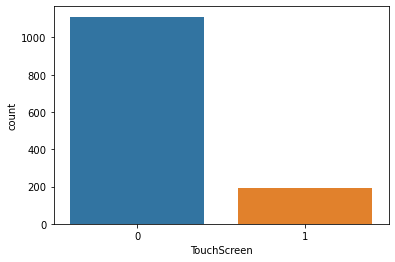

In [139]:
sns.countplot(df['TouchScreen']);

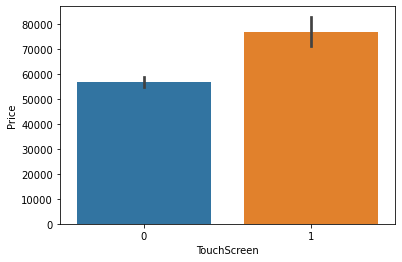

In [140]:
# comparison of touch screen with price

sns.barplot('TouchScreen', 'Price', data=df);

*The above graph indicates, price of laptop is higher if it is touch screen and converse*

In [141]:
# creating another variable for IPS panel

df['IPS'] = df['ScreenResolution'].apply(lambda ele :1 if 'IPS' in ele else 0)

df.sample(5)

Company            TypeName  Inches  \
207     Dell           Ultrabook    13.3   
1098      HP            Notebook    15.6   
537       HP            Notebook    15.6   
758     Dell              Gaming    15.6   
1040  Lenovo  2 in 1 Convertible    15.6   

                                   ScreenResolution  \
207   IPS Panel 4K Ultra HD / Touchscreen 3840x2160   
1098                                       1366x768   
537                               Full HD 1920x1080   
758                 IPS Panel 4K Ultra HD 3840x2160   
1040      IPS Panel Full HD / Touchscreen 1920x1080   

                                       Cpu  Ram                Memory  \
207             Intel Core i7 8550U 1.8GHz    8             256GB SSD   
1098  Intel Pentium Quad Core N3710 1.6GHz    4               1TB HDD   
537   Intel Pentium Quad Core N3710 1.6GHz    4             256GB SSD   
758            Intel Core i7 7700HQ 2.8GHz   16  256GB SSD +  1TB HDD   
1040            Intel Core i7 6500U 2.5GHz    4             256GB SSD   

                          Gpu       OpSys  Weight        Price  TouchScreen  \
207    Intel UHD Graphics 620  Windows 10    1.21  103842.7200            1   
1098    Intel HD Graphics 405  Windows 10    1.96   26640.0000            0   
537     Intel HD Graphics 405  Windows 10    1.86   21258.1872            0   
758   Nvidia GeForce GTX 1070  Windows 10    4.42  152859.7872            0   
1040    Intel HD Graphics 520  Windows 10    1.80   45128.1600            1   

      IPS  
207     1  
1098    0  
537     0  
758     1  
1040    1

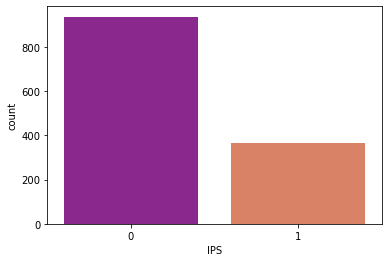

In [142]:
sns.countplot(df['IPS'], palette='plasma');

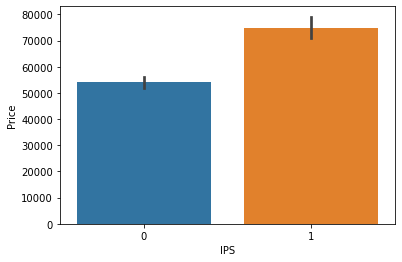

In [143]:
# comparison of touch screen with price

sns.barplot('IPS', 'Price', data=df);

**Next step:**

It is clear in the data that, each unique value of Screen resolution has width and height of pixel value in it, 
next step is to extract the resolution size from the data.

In [144]:
splitdf = df['ScreenResolution'].str.split('x', n=1, expand=True) # expand gives result in a df
splitdf.head()

# take the x resolution
df['X_res'] = splitdf[0]
df['Y_res'] = splitdf[1]

df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

                           X_res Y_res  
0  IPS Panel Retina Display 2560  1600  
1                           1440   900  
2                   Full HD 1920  1080  
3  IPS Panel Retina Display 2880  1800  
4  IPS Panel Retina Display 2560  1600

In [145]:
# extracting only X resolution from chunk of text in X_res column using regex

# extracting only the pixel values (last 4 digits) and few records has comma in it, so removing them
df['X_res'] = df['X_res'].str.replace(',','').str.findall(r'(\d+\d)').apply(lambda x:x[0])
df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

  X_res Y_res  
0  2560  1600  
1  1440   900  
2  1920  1080  
3  2880  1800  
4  2560  1600

In [146]:
df['X_res'] = df['X_res'].astype('int32')
df['Y_res'] = df['Y_res'].astype('int32')

**Note:**
    
Screen resolution feature has been splitted into 4 different new features which may or may not give better understanding 
of the target variable, trial and error method applicable here  

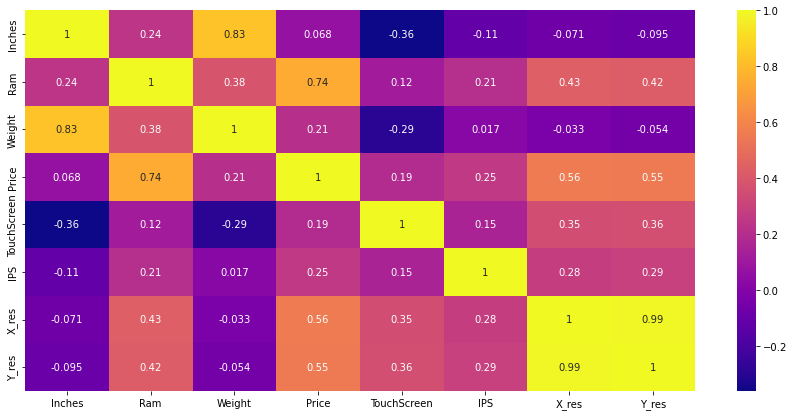

In [147]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, cmap='plasma');

> From above matrix, it is known that there is high correlation between X resolution and Y resolution as both are single variable splitted into two halves 

In [148]:
df.corr()['Price']

Inches         0.068197
Ram            0.743007
Weight         0.210370
Price          1.000000
TouchScreen    0.191226
IPS            0.252208
X_res          0.556529
Y_res          0.552809
Name: Price, dtype: float64

**From correlation values, both X_res and Y_res has positive relation with Price variable. So that's why we have splitted the variable into two. when X_res and Y_res increases, Price also increases and same is with Ram variable.**

**But there could be a problem of collinearity with resolution, so we will try to combine resolution with inches to create a new variable `PPI{Pixels per inch}` using formula instead of dropping one feature. here the domain knowledge about laptop comes into play.**



In [149]:
df['PPI'] = (((df['X_res'] ** 2 + df['Y_res'] ** 2) ** 0.5) / (df['Inches'])).astype('float32')
df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

   X_res  Y_res         PPI  
0   2560   1600  226.983002  
1   1440    900  127.677940  
2   1920   1080  141.212006  
3   2880   1800  220.534622  
4   2560   1600  226.983002

In [150]:
# Now we will look into correlation matrix 

df.corr()['Price']

Inches         0.068197
Ram            0.743007
Weight         0.210370
Price          1.000000
TouchScreen    0.191226
IPS            0.252208
X_res          0.556529
Y_res          0.552809
PPI            0.473487
Name: Price, dtype: float64

> Now it is evident, combination of inches, X_res, Y_res gives good amount of correlation with target varaible Price, so we can drop all three variables.

In [151]:
df.drop(['Inches', 'X_res', 'Y_res'], axis=1, inplace=True)
df.head()

Company   TypeName                    ScreenResolution  \
0   Apple  Ultrabook  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook                            1440x900   
2      HP   Notebook                   Full HD 1920x1080   
3   Apple  Ultrabook  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

          PPI  
0  226.983002  
1  127.677940  
2  141.212006  
3  220.534622  
4  226.983002

In [152]:
# remove the base feature Screen Resolution 

df.drop(['ScreenResolution'], axis=1, inplace=True)
df.head()

Company   TypeName                         Cpu  Ram               Memory  \
0   Apple  Ultrabook        Intel Core i5 2.3GHz    8            128GB SSD   
1   Apple  Ultrabook        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2      HP   Notebook  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3   Apple  Ultrabook        Intel Core i7 2.7GHz   16            512GB SSD   
4   Apple  Ultrabook        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

          PPI  
0  226.983002  
1  127.677940  
2  141.212006  
3  220.534622  
4  226.983002

**Conclusion about Screen Resolution feature:**
    
The feature is finally divided into three columns which are Touch Screen, IPS panel availability and 
Pixel per inches

*Next we will focus on CPU column*

In [153]:
df['Cpu'].value_counts()

Intel Core i5 7200U 2.5GHz               190
Intel Core i7 7700HQ 2.8GHz              146
Intel Core i7 7500U 2.7GHz               134
Intel Core i7 8550U 1.8GHz                73
Intel Core i5 8250U 1.6GHz                72
Intel Core i5 6200U 2.3GHz                68
Intel Core i3 6006U 2GHz                  64
Intel Core i7 6500U 2.5GHz                49
Intel Core i7 6700HQ 2.6GHz               43
Intel Core i3 7100U 2.4GHz                37
Intel Core i5 7300HQ 2.5GHz               33
Intel Celeron Dual Core N3350 1.1GHz      30
Intel Celeron Dual Core N3060 1.6GHz      28
Intel Core i7 6600U 2.6GHz                18
Intel Core i3 6006U 2.0GHz                16
Intel Pentium Quad Core N4200 1.1GHz      14
Intel Core i5 7300U 2.6GHz                14
Intel Core i7 7600U 2.8GHz                13
Intel Pentium Quad Core N3710 1.6GHz      11
AMD A9-Series 9420 3GHz                   11
Intel Core i5 6300U 2.4GHz                11
Intel Celeron Dual Core N3050 1.6GHz      11
Intel Core

**In this column, we will consider first three words like Intel core i5 and consider other Intel variations as 'Other' category and also AMD is other separate category. We will neglect clock speed and frequency as of now**

**So we observe that first three words gives the type of CPU, so we will extract those first** 

In [154]:
df['CPU_name'] = df['Cpu'].apply(lambda x: " ".join(x.split()[:3]))
df

Company            TypeName                                    Cpu  \
0         Apple           Ultrabook                   Intel Core i5 2.3GHz   
1         Apple           Ultrabook                   Intel Core i5 1.8GHz   
2            HP            Notebook             Intel Core i5 7200U 2.5GHz   
3         Apple           Ultrabook                   Intel Core i7 2.7GHz   
4         Apple           Ultrabook                   Intel Core i5 3.1GHz   
5          Acer            Notebook                AMD A9-Series 9420 3GHz   
6         Apple           Ultrabook                   Intel Core i7 2.2GHz   
7         Apple           Ultrabook                   Intel Core i5 1.8GHz   
8          Asus           Ultrabook             Intel Core i7 8550U 1.8GHz   
9          Acer           Ultrabook             Intel Core i5 8250U 1.6GHz   
10           HP            Notebook             Intel Core i5 7200U 2.5GHz   
11           HP            Notebook               Intel Core i3 6006U 2GHz   
12        Apple           Ultrabook                   Intel Core i7 2.8GHz   
13         Dell            Notebook               Intel Core i3 6006U 2GHz   
14        Apple           Ultrabook                 Intel Core M m3 1.2GHz   
15        Apple           Ultrabook                   Intel Core i5 2.3GHz   
16         Dell            Notebook             Intel Core i7 7500U 2.7GHz   
17        Apple           Ultrabook                   Intel Core i7 2.9GHz   
18       Lenovo            Notebook             Intel Core i3 7100U 2.4GHz   
19         Dell           Ultrabook             Intel Core i5 8250U 1.6GHz   
20         Asus             Netbook            Intel Atom x5-Z8350 1.44GHz   
21       Lenovo              Gaming            Intel Core i5 7300HQ 2.5GHz   
22           HP            Notebook           AMD E-Series E2-9000e 1.5GHz   
23         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
24           HP           Ultrabook             Intel Core i7 8550U 1.8GHz   
25         Dell            Notebook               Intel Core i3 6006U 2GHz   
26        Apple           Ultrabook                   Intel Core i5 1.6GHz   
27         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
28         Dell           Ultrabook             Intel Core i7 8650U 1.9GHz   
29           HP            Notebook             Intel Core i5 8250U 1.6GHz   
30        Chuwi            Notebook            Intel Atom x5-Z8300 1.44GHz   
31         Asus            Notebook            AMD E-Series E2-6110 1.5GHz   
32           HP            Notebook              AMD A6-Series 9220 2.5GHz   
33         Dell           Ultrabook             Intel Core i7 8550U 1.8GHz   
34        Apple           Ultrabook                   Intel Core i5 1.6GHz   
35       Lenovo            Notebook   Intel Celeron Dual Core N3350 1.1GHz   
36         Acer            Notebook             Intel Core i3 7130U 2.7GHz   
37         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
38           HP            Notebook             Intel Core i5 7200U 2.5GHz   
39           HP            Notebook             Intel Core i5 8250U 1.6GHz   
40         Asus            Notebook               Intel Core i3 6006U 2GHz   
41         Dell              Gaming            Intel Core i7 7700HQ 2.8GHz   
42         Asus            Notebook             Intel Core i5 7200U 2.5GHz   
43         Acer            Notebook             Intel Core i5 8250U 1.6GHz   
44         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
45        Apple           Ultrabook                   Intel Core i5 2.0GHz   
46       Lenovo            Notebook               Intel Core i3 6006U 2GHz   
47         Asus              Gaming                    AMD Ryzen 1700 3GHz   
48         Dell            Notebook             Intel Core i5 7200U 2.5GHz   
49         Asus            Notebook   Intel Pentium Quad Core N4200 1.1GHz   
50       Lenovo  2 in 1 Conver

In [155]:
"""
Function which gives out Intel variants as it is when the input is i3, i5, or i7..
if it is other intel variants, return other intel and return AMD processor for other different
variants
"""

def preprocessortype(text):
    # reducing into three categories
    
    if text in ['Intel Core i7', 'Intel Core i5', 'Intel Core i3']:
        return text
    else:
        if text.split()[0] == 'Intel':
            return "Other Intel Processor"
        else:
            return "AMD Processor"
        
df['CPU_name']  = df['CPU_name'].apply(lambda text: preprocessortype(text))
df


Company            TypeName                                    Cpu  \
0         Apple           Ultrabook                   Intel Core i5 2.3GHz   
1         Apple           Ultrabook                   Intel Core i5 1.8GHz   
2            HP            Notebook             Intel Core i5 7200U 2.5GHz   
3         Apple           Ultrabook                   Intel Core i7 2.7GHz   
4         Apple           Ultrabook                   Intel Core i5 3.1GHz   
5          Acer            Notebook                AMD A9-Series 9420 3GHz   
6         Apple           Ultrabook                   Intel Core i7 2.2GHz   
7         Apple           Ultrabook                   Intel Core i5 1.8GHz   
8          Asus           Ultrabook             Intel Core i7 8550U 1.8GHz   
9          Acer           Ultrabook             Intel Core i5 8250U 1.6GHz   
10           HP            Notebook             Intel Core i5 7200U 2.5GHz   
11           HP            Notebook               Intel Core i3 6006U 2GHz   
12        Apple           Ultrabook                   Intel Core i7 2.8GHz   
13         Dell            Notebook               Intel Core i3 6006U 2GHz   
14        Apple           Ultrabook                 Intel Core M m3 1.2GHz   
15        Apple           Ultrabook                   Intel Core i5 2.3GHz   
16         Dell            Notebook             Intel Core i7 7500U 2.7GHz   
17        Apple           Ultrabook                   Intel Core i7 2.9GHz   
18       Lenovo            Notebook             Intel Core i3 7100U 2.4GHz   
19         Dell           Ultrabook             Intel Core i5 8250U 1.6GHz   
20         Asus             Netbook            Intel Atom x5-Z8350 1.44GHz   
21       Lenovo              Gaming            Intel Core i5 7300HQ 2.5GHz   
22           HP            Notebook           AMD E-Series E2-9000e 1.5GHz   
23         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
24           HP           Ultrabook             Intel Core i7 8550U 1.8GHz   
25         Dell            Notebook               Intel Core i3 6006U 2GHz   
26        Apple           Ultrabook                   Intel Core i5 1.6GHz   
27         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
28         Dell           Ultrabook             Intel Core i7 8650U 1.9GHz   
29           HP            Notebook             Intel Core i5 8250U 1.6GHz   
30        Chuwi            Notebook            Intel Atom x5-Z8300 1.44GHz   
31         Asus            Notebook            AMD E-Series E2-6110 1.5GHz   
32           HP            Notebook              AMD A6-Series 9220 2.5GHz   
33         Dell           Ultrabook             Intel Core i7 8550U 1.8GHz   
34        Apple           Ultrabook                   Intel Core i5 1.6GHz   
35       Lenovo            Notebook   Intel Celeron Dual Core N3350 1.1GHz   
36         Acer            Notebook             Intel Core i3 7130U 2.7GHz   
37         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
38           HP            Notebook             Intel Core i5 7200U 2.5GHz   
39           HP            Notebook             Intel Core i5 8250U 1.6GHz   
40         Asus            Notebook               Intel Core i3 6006U 2GHz   
41         Dell              Gaming            Intel Core i7 7700HQ 2.8GHz   
42         Asus            Notebook             Intel Core i5 7200U 2.5GHz   
43         Acer            Notebook             Intel Core i5 8250U 1.6GHz   
44         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
45        Apple           Ultrabook                   Intel Core i5 2.0GHz   
46       Lenovo            Notebook               Intel Core i3 6006U 2GHz   
47         Asus              Gaming                    AMD Ryzen 1700 3GHz   
48         Dell            Notebook             Intel Core i5 7200U 2.5GHz   
49         Asus            Notebook   Intel Pentium Quad Core N4200 1.1GHz   
50       Lenovo  2 in 1 Conver

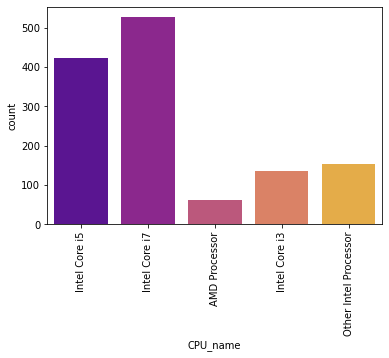

In [156]:
sns.countplot(df['CPU_name'], palette='plasma')
plt.xticks(rotation='vertical');

**So, we have reduced different type of CPU processors into 5 categories**

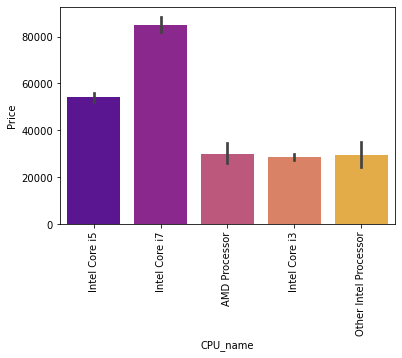

In [157]:
# comparison of new column with Price

sns.barplot(df['CPU_name'], df['Price'],palette='plasma')
plt.xticks(rotation='vertical');

In [158]:
# dropping CPU column 

df.drop(['Cpu'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram               Memory                           Gpu  \
0   Apple  Ultrabook    8            128GB SSD  Intel Iris Plus Graphics 640   
1   Apple  Ultrabook    8  128GB Flash Storage        Intel HD Graphics 6000   
2      HP   Notebook    8            256GB SSD         Intel HD Graphics 620   
3   Apple  Ultrabook   16            512GB SSD            AMD Radeon Pro 455   
4   Apple  Ultrabook    8            256GB SSD  Intel Iris Plus Graphics 650   

   OpSys  Weight        Price  TouchScreen  IPS         PPI       CPU_name  
0  macOS    1.37   71378.6832            0    1  226.983002  Intel Core i5  
1  macOS    1.34   47895.5232            0    0  127.677940  Intel Core i5  
2  No OS    1.86   30636.0000            0    0  141.212006  Intel Core i5  
3  macOS    1.83  135195.3360            0    1  220.534622  Intel Core i7  
4  macOS    1.37   96095.8080            0    1  226.983002  Intel Core i5

##### Analysis on Ram column 

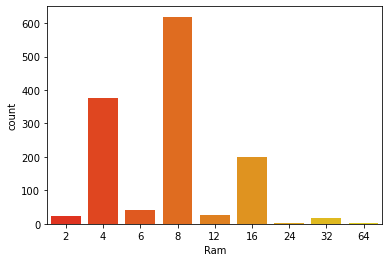

In [159]:
sns.countplot(df['Ram'], palette='autumn');

> Most common laptops have 4, 6 and 16 GB as the RAM 

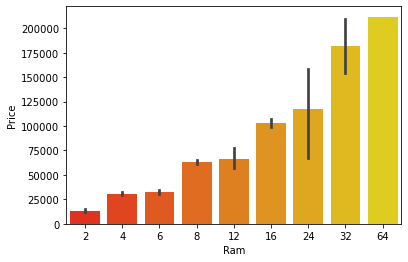

In [160]:
# comparison of ram with price 

sns.barplot(df['Ram'], df['Price'], palette='autumn');

**We could see a increasing trend here, as Ram increases the average price of the laptop also increases**

**About the memory column**

we have different type of categories like SSD, HDD, combination of SSD & HDD etc.. 

Need to pre process the text and drill down to few categories.

In [161]:
df['Memory'].value_counts()

256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

In [162]:
## most common observed categories are SSD, HDD, flash and hybrid 

# to remove decimal place ex: 1.0TB -> 1TB
df['Memory'] = df['Memory'].str.replace('\.0', '', regex=True)

# replace GB with space
df['Memory'] = df['Memory'].str.replace('GB', '')

#replace the TB word with 000 (maintaining GB as common measure)
df['Memory'] = df['Memory'].str.replace('TB', '000')

# split the word across "+" character
newdf = df['Memory'].str.split("+", n=1, expand=True)
newdf.head()


0     1
0            128 SSD  None
1  128 Flash Storage  None
2            256 SSD  None
3            512 SSD  None
4            256 SSD  None

In [163]:
df['Memory'].sample(20)

540                    256 SSD
1101                   128 SSD
662                    500 HDD
1087                   180 SSD
1208                  1000 HDD
1068       256 SSD +  1000 HDD
54                    1000 HDD
295                   1000 HDD
302                   1000 HDD
687                   1000 HDD
652                    256 SSD
873                    180 SSD
1069         256 Flash Storage
21         128 SSD +  1000 HDD
512                   1000 HDD
710        128 SSD +  1000 HDD
395                    256 SSD
151                1000 Hybrid
121        256 SSD +  2000 HDD
1116    256 SSD +  1000 Hybrid
Name: Memory, dtype: object

> Maintaining all above numeric values in GB only 

In [164]:
# now splitting the first part and stripping off the spaces 

df['first'] = newdf[0]
df['first'] = df['first'].str.strip()
df.sample(10)

Company            TypeName  Ram               Memory  \
1054    Dell           Ultrabook   16             1000 SSD   
1143      HP         Workstation    8              256 SSD   
685     Dell              Gaming   16  256 SSD +  1000 HDD   
1285  Lenovo  2 in 1 Convertible   16              512 SSD   
828     Acer             Netbook    4     32 Flash Storage   
52        HP            Notebook    4              256 SSD   
545       HP            Notebook    4              128 SSD   
95      Acer  2 in 1 Convertible    8              256 SSD   
425     Dell              Gaming    8  128 SSD +  1000 HDD   
219     Dell  2 in 1 Convertible   16              512 SSD   

                             Gpu       OpSys  Weight        Price  \
1054       Intel HD Graphics 620  Windows 10    1.20  120093.1200   
1143        Nvidia Quadro M1000M   Windows 7    2.59  118761.1200   
685      Nvidia GeForce GTX 1070  Windows 10    3.49  149916.6000   
1285       Intel HD Graphics 520  Windows 10    1.30   79866.7200   
828        Intel HD Graphics 400   Chrome OS    1.35   18914.4000   
52        AMD Radeon R4 Graphics  Windows 10    1.86   21231.5472   
545        Intel HD Graphics 620  Windows 10    2.10   37589.0400   
95        Intel UHD Graphics 620  Windows 10    1.50   45128.1600   
425   Nvidia GeForce GTX 1050 Ti  Windows 10    2.62   61751.5200   
219       Intel UHD Graphics 620  Windows 10    1.62   68145.1200   

      TouchScreen  IPS         PPI               CPU_name             first  
1054            1    0  276.053528          Intel Core i7          1000 SSD  
1143            0    1  141.212006          Intel Core i7           256 SSD  
685             0    0  141.212006          Intel Core i7           256 SSD  
1285            1    1  276.053528          Intel Core i7           512 SSD  
828             0    1  135.094208  Other Intel Processor  32 Flash Storage  
52              0    0  141.212006          AMD Processor           256 SSD  
545             0    0  141.212006          Intel Core i3           128 SSD  
95              1    1  165.632111          Intel Core i5           256 SSD  
425             0    1  141.212006          Intel Core i7           128 SSD  
219             1    0  165.632111          Intel Core i7           512 SSD

In [165]:
# performing one hot encoding on first column which gives four new variables as below

def one_hot_encoding(val):
    df['Memory'+val] = df['first'].apply(lambda x: 1 if val in x else 0)


list_to_apply = ['SSD', 'HDD', 'Hybrid', 'FlashStorage']
for val in list_to_apply:
    one_hot_encoding(val)
    
df.sample(10)

Company            TypeName  Ram               Memory  \
956     Dell  2 in 1 Convertible    8              256 SSD   
79        HP            Notebook    8  128 SSD +  1000 HDD   
33      Dell           Ultrabook   16              512 SSD   
716     Dell            Notebook    8              256 SSD   
85      Dell              Gaming   16  128 SSD +  1000 HDD   
1179      HP            Notebook    4              500 HDD   
589     Asus              Gaming    8  128 SSD +  1000 HDD   
385   Lenovo           Ultrabook    8              512 SSD   
95      Acer  2 in 1 Convertible    8              256 SSD   
69      Asus              Gaming   12             1000 HDD   

                             Gpu       OpSys  Weight      Price  TouchScreen  \
956        Intel HD Graphics 615  Windows 10    1.24  101178.72            1   
79          Nvidia GeForce 930MX  Windows 10    2.50   52054.56            0   
33        Intel UHD Graphics 620  Windows 10    1.20   99580.32            1   
716        Intel HD Graphics 620  Windows 10    1.90   62817.12            0   
85    Nvidia GeForce GTX 1050 Ti  Windows 10    2.65   71874.72            0   
1179       Intel HD Graphics 520  Windows 10    2.07   34632.00            0   
589      Nvidia GeForce GTX 1060  Windows 10    2.73   94305.60            0   
385        Intel HD Graphics 620  Windows 10    1.13  121584.96            0   
95        Intel UHD Graphics 620  Windows 10    1.50   45128.16            1   
69    Nvidia GeForce GTX 1050 Ti       Linux    3.00   50562.72            0   

      IPS         PPI       CPU_name     first  MemorySSD  MemoryHDD  \
956     0  165.632111  Intel Core i5   256 SSD          1          0   
79      0  127.335678  Intel Core i5   128 SSD          1          0   
33      0  276.053528  Intel Core i7   512 SSD          1          0   
716     0  141.212006  Intel Core i5   256 SSD          1          0   
85      1  141.212006  Intel Core i7   128 SSD          1          0   
1179    0  100.454666  Intel Core i3   500 HDD          0          1   
589     1  127.335678  Intel Core i5   128 SSD          1          0   
385     1  209.800690  Intel Core i7   512 SSD          1          0   
95      1  165.632111  Intel Core i5   256 SSD          1          0   
69      0  127.335678  Intel Core i7  1000 HDD          0          1   

      MemoryHybrid  MemoryFlashStorage  
956              0                   0  
79               0                   0  
33               0                   0  
716              0                   0  
85               0                   0  
1179             0                   0  
589              0                   0  
385              0                   0  
95               0                   0  
69               0                   0

In [166]:
# removing all characters in the first column as we have created separate columns for memory categories

df['first'] = df['first'].str.replace('\D','')
df['first']

0        128
1        128
2        256
3        512
4        256
5        500
6        256
7        256
8        512
9        256
10       500
11       500
12       256
13       256
14       256
15       256
16       256
17       512
18      1000
19       128
20        32
21       128
22       500
23       256
24       256
25      1000
26       128
27       256
28       256
29      1000
30        64
31        32
32       500
33       512
34       256
35        64
36      1000
37       128
38      1000
39       256
40      1000
41       256
42      1000
43       256
44      1000
45       256
46       128
47       256
48       256
49      1000
50        64
51       256
52       256
53       512
54      1000
55       256
56       128
57       256
58       256
59       256
60       256
61       256
62       256
63       256
64       256
65       512
66       500
67        32
68      1000
69      1000
70       128
71       256
72       256
73       128
74      1000
75      1000
76      2000

In [167]:
# to get the second combination of memory (which is SSD plus HDD)

df['second'] = newdf[1]
df.sample(10)

Company   TypeName  Ram   Memory                    Gpu       OpSys  \
64         HP   Notebook    8  256 SSD  Intel HD Graphics 620  Windows 10   
407      Dell  Ultrabook    8  512 SSD      Intel HD Graphics  Windows 10   
1302     Asus   Notebook    4  500 HDD      Intel HD Graphics  Windows 10   
981   Toshiba   Notebook    4  128 SSD  Intel HD Graphics 520   Windows 7   
579      Dell   Notebook    8  256 SSD     AMD Radeon R5 M430       Linux   
1035       HP  Ultrabook    8  256 SSD  Intel HD Graphics 520  Windows 10   
381    Lenovo   Notebook    4  128 SSD  Intel HD Graphics 520       No OS   
772   Toshiba   Notebook    4  128 SSD  Intel HD Graphics 520  Windows 10   
1179       HP   Notebook    4  500 HDD  Intel HD Graphics 520  Windows 10   
597    Lenovo   Notebook    8  256 SSD  Intel HD Graphics 630  Windows 10   

      Weight       Price  TouchScreen  IPS         PPI               CPU_name  \
64      1.86  36763.2000            0    0  141.212006          Intel Core i5   
407     1.36  89510.4000            0    0  157.350510          Intel Core i7   
1302    2.20  19660.3200            0    0  100.454666  Other Intel Processor   
981     1.20  63669.6000            0    0  165.632111          Intel Core i5   
579     2.20  39907.2528            0    0  141.212006          Intel Core i7   
1035    1.26  71874.7200            0    0  176.232574          Intel Core i7   
381     1.85  21498.4800            0    0  141.212006          Intel Core i3   
772     1.75  54345.6000            0    1  111.935204          Intel Core i5   
1179    2.07  34632.0000            0    0  100.454666          Intel Core i3   
597     1.70  78534.7200            0    1  157.350510          Intel Core i5   

     first  MemorySSD  MemoryHDD  MemoryHybrid  MemoryFlashStorage second  
64     256          1          0             0                   0   None  
407    512          1          0             0                   0   None  
1302   500          0          1             0                   0   None  
981    128          1          0             0                   0   None  
579    256          1          0             0                   0   None  
1035   256          1          0             0                   0   None  
381    128          1          0             0                   0   None  
772    128          1          0             0                   0   None  
1179   500          0          1             0                   0   None  
597    256          1          0             0                   0   None

In [168]:
# performing same one hot encoding on second column which gives four new variables as below

def one_hot_encoding(val):
    df['Memory_2'+val] = df['second'].apply(lambda x: 1 if val in x else 0)


list_to_apply = ['SSD', 'HDD', 'Hybrid', 'FlashStorage']
df['second'] = df['second'].fillna("0") # because there are many None records
for val in list_to_apply:
    one_hot_encoding(val)
    
df['second'] = df['second'].str.replace(r'\D','')

df.sample(10)

Company            TypeName  Ram               Memory  \
163    Lenovo              Gaming   16              256 SSD   
878      Dell            Notebook    4  128 SSD +  1000 HDD   
862   Toshiba            Notebook    4              128 SSD   
284      Acer            Notebook    8              256 SSD   
974      Asus              Gaming   16  256 SSD +  1000 HDD   
122    Lenovo            Notebook    8              256 SSD   
481      Dell            Notebook    4             1000 HDD   
127      Asus            Notebook    4               64 SSD   
64         HP            Notebook    8              256 SSD   
1144       HP  2 in 1 Convertible    8              256 SSD   

                             Gpu         OpSys  Weight        Price  \
163   Nvidia GeForce GTX 1050 Ti    Windows 10    2.50   57489.1200   
878         Nvidia GeForce 940MX    Windows 10    2.18   48618.0000   
862        Intel HD Graphics 620    Windows 10    1.05   68464.8000   
284         Nvidia GeForce MX150    Windows 10    3.00   50669.2800   
974      Nvidia GeForce GTX 1060    Windows 10    2.73  109218.6720   
122         Nvidia GeForce 940MX         No OS    2.20   33513.1200   
481        Intel HD Graphics 620    Windows 10    2.18   31254.0480   
127                AMD Radeon R2  Windows 10 S    1.65   14811.3072   
64         Intel HD Graphics 620    Windows 10    1.86   36763.2000   
1144       Intel HD Graphics 520    Windows 10    1.48   95850.7200   

      TouchScreen  IPS         PPI       CPU_name first  MemorySSD  MemoryHDD  \
163             0    1  141.212006  Intel Core i7   256          1          0   
878             0    0  141.212006  Intel Core i5   128          1          0   
862             0    0  165.632111  Intel Core i5   128          1          0   
284             0    1  141.212006  Intel Core i7   256          1          0   
974             0    0  127.335678  Intel Core i7   256          1          0   
122             0    0  141.212006  Intel Core i5   256          1          0   
481             0    0  100.454666  Intel Core i3  1000          0          1   
127             0    0  111.935204  AMD Processor    64          1          0   
64              0    0  141.212006  Intel Core i5   256          1          0   
1144            1    0  220.842819  Intel Core i7   256          1          0   

      MemoryHybrid  MemoryFlashStorage second  Memory_2SSD  Memory_2HDD  \
163              0                   0      0            0            0   
878              0                   0   1000            0            1   
862              0                   0      0            0            0   
284              0                   0      0            0            0   
974              0                   0   1000            0            1   
122              0                   0      0            0            0   
481              0                   0      0            0            0   
127              0                   0      0            0            0   
64               0                   0      0            0            0   
1144             0                   0      0            0            0   

      Memory_2Hybrid  Memory_2FlashStorage  
163                0                     0  
878                0                     0  
862                0                     0  
284                0                     0  
974                0                     0  
122                0                     0  
481                0                     0  
127                0                     0  
64                 0                     0  
1144               0                     0

In [169]:
df.sample(15)

Company            TypeName  Ram               Memory  \
1237     Dell            Notebook    4              500 HDD   
947    Lenovo            Notebook    8             1000 HDD   
933    Lenovo  2 in 1 Convertible   16             1000 SSD   
1067     Dell  2 in 1 Convertible    8              256 SSD   
944    Lenovo  2 in 1 Convertible    8              256 SSD   
178    Lenovo            Notebook    8  128 SSD +  1000 HDD   
289    Lenovo            Notebook    8             1000 HDD   
107      Asus           Ultrabook    8              256 SSD   
1041     Vero            Notebook    2     32 Flash Storage   
943   Toshiba            Notebook    8              256 SSD   
303    Lenovo            Notebook    8             2000 HDD   
503    Lenovo            Notebook    4              500 HDD   
691    Lenovo            Notebook    4              256 SSD   
532      Asus            Notebook    8  256 SSD +  1000 HDD   
851      Asus              Gaming   16  128 SSD +  1000 HDD   

                          Gpu       OpSys  Weight        Price  TouchScreen  \
1237    Intel HD Graphics 520   Windows 7    2.24   39267.3600            0   
947      Nvidia GeForce 920MX       No OS    2.20   36496.8000            0   
933   Intel Iris Graphics 540  Windows 10    1.30   95850.7200            1   
1067    Intel HD Graphics 520  Windows 10    1.62   42517.9728            1   
944     Intel HD Graphics 515  Windows 10    1.10   69210.7200            1   
178            AMD R17M-M1-70  Windows 10    1.90   43316.6400            0   
289      Nvidia GeForce 940MX       No OS    2.20   35112.0528            0   
107      Nvidia GeForce 940MX  Windows 10    1.30   63563.0400            0   
1041    Intel HD Graphics 400  Windows 10    1.45   11231.4240            0   
943     Intel HD Graphics 520  Windows 10    2.20   59620.3200            0   
303      Nvidia GeForce 940MX       No OS    2.20   29250.7200            0   
503     Intel HD Graphics 500  Windows 10    2.10   15930.7200            0   
691     Intel HD Graphics 620  Windows 10    1.70   37242.7200            0   
532   Nvidia GeForce GTX 960M  Windows 10    2.00   69210.7200            0   
851   Nvidia GeForce GTX 1060  Windows 10    2.10  101178.7200            0   

      IPS         PPI               CPU_name first  MemorySSD  MemoryHDD  \
1237    0  100.454666          Intel Core i5   500          0          1   
947     0  141.212006          Intel Core i7  1000          0          1   
933     1  276.053528          Intel Core i7  1000          1          0   
1067    0  165.632111          Intel Core i7   256          1          0   
944     1  194.947540  Other Intel Processor   256          1          0   
178     0  141.212006          Intel Core i5   128          1          0   
289     0  141.212006          Intel Core i7  1000          0          1   
107     1  157.350510          Intel Core i7   256          1          0   
1041    0  111.935204  Other Intel Processor    32          0          0   
943     0  100.454666          Intel Core i5   256          1          0   
303     0  100.454666          Intel Core i5  2000          0          1   
503     0  111.935204  Other Intel Processor   500          0          1   
691     0  157.350510          Intel Core i5   256          1          0   
532     1  282.424011          Intel Core i7   256          1          0   
851     0  141.212006          Intel Core i7   128          1          0   

      MemoryHybrid  MemoryFlashStorage second  Memory_2SSD  Memory_2HDD  \
1237             0                   0      0            0            0   
947              0                   0      0            0            0   
933              0                   0      0            0            0   
1067             0                   0      0            0            0   
944              0                   0      0            0            0   
178              0                   0   1000            0       

In [170]:
df['first'] = df['first'].astype('int32')
df['second'] = df['second'].astype('int32')

In [171]:
df['second'].value_counts()

0       1095
1000     187
2000      15
256        3
500        2
512        1
Name: second, dtype: int64

> Create a four new variables which will have all above derived data in a meaningful manner.

In [172]:
df['HDD'] = df['first'] * df['MemoryHDD'] + df['second'] * df['Memory_2HDD']
df['SSD'] = df['first'] * df['MemorySSD'] + df['second'] * df['Memory_2SSD']
df['Hybrid'] = df['first'] * df['MemoryHybrid'] + df['second'] * df['Memory_2Hybrid']
df['FlashStorage'] = df['first'] * df['MemoryFlashStorage'] + df['second'] * df['Memory_2FlashStorage']


# dropping unnecessary columns

df.drop(['first', 'second', 'MemorySSD','MemoryHDD','MemoryHybrid', 'MemoryFlashStorage',
        'Memory_2SSD','Memory_2HDD','Memory_2Hybrid', 'Memory_2FlashStorage'], axis=1,inplace=True)

In [173]:
df.sample(10)

Company     TypeName  Ram    Memory                     Gpu       OpSys  \
768   Samsung    Ultrabook    8   256 SSD   Intel HD Graphics 620  Windows 10   
929        HP     Notebook    4   500 HDD   Intel HD Graphics 520  Windows 10   
11         HP     Notebook    4   500 HDD   Intel HD Graphics 520       No OS   
1022       HP     Notebook    8   256 SSD   Intel HD Graphics 620  Windows 10   
208      Dell    Ultrabook    8   256 SSD  Intel UHD Graphics 620  Windows 10   
914      Acer     Notebook    4  1000 HDD   Intel HD Graphics 620  Windows 10   
1207   Lenovo     Notebook    4   500 HDD  AMD Radeon R2 Graphics  Windows 10   
1143       HP  Workstation    8   256 SSD    Nvidia Quadro M1000M   Windows 7   
398      Dell  Workstation    8   256 SSD     Nvidia Quadro M1200  Windows 10   
479   Toshiba     Notebook    8   256 SSD   Intel HD Graphics 620  Windows 10   

      Weight        Price  TouchScreen  IPS         PPI       CPU_name   HDD  \
768     1.31   85194.7200            1    0  165.632111  Intel Core i7     0   
929     1.95   61218.7200            0    0  111.935204  Intel Core i5   500   
11      1.86   18381.0672            0    0  141.212006  Intel Core i3   500   
1022    1.11   61218.7200            0    1  165.632111  Intel Core i5     0   
208     1.20   77202.7200            0    0  165.632111  Intel Core i7     0   
914     2.40   26586.7200            0    0  141.212006  Intel Core i3  1000   
1207    2.20   15930.7200            0    0  100.454666  AMD Processor   500   
1143    2.59  118761.1200            0    1  141.212006  Intel Core i7     0   
398     1.78  144495.3600            1    0  282.424011  Intel Core i7     0   
479     1.05   89084.1600            0    1  165.632111  Intel Core i5     0   

      SSD  Hybrid  FlashStorage  
768   256       0             0  
929     0       0             0  
11      0       0             0  
1022  256       0             0  
208   256       0             0  
914     0       0             0  
1207    0       0             0  
1143  256       0             0  
398   256       0             0  
479   256       0             0

In [174]:
# removing the base column which is Memory 

df.drop(['Memory'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram                           Gpu  OpSys  Weight  \
0   Apple  Ultrabook    8  Intel Iris Plus Graphics 640  macOS    1.37   
1   Apple  Ultrabook    8        Intel HD Graphics 6000  macOS    1.34   
2      HP   Notebook    8         Intel HD Graphics 620  No OS    1.86   
3   Apple  Ultrabook   16            AMD Radeon Pro 455  macOS    1.83   
4   Apple  Ultrabook    8  Intel Iris Plus Graphics 650  macOS    1.37   

         Price  TouchScreen  IPS         PPI       CPU_name  HDD  SSD  Hybrid  \
0   71378.6832            0    1  226.983002  Intel Core i5    0  128       0   
1   47895.5232            0    0  127.677940  Intel Core i5    0    0       0   
2   30636.0000            0    0  141.212006  Intel Core i5    0  256       0   
3  135195.3360            0    1  220.534622  Intel Core i7    0  512       0   
4   96095.8080            0    1  226.983002  Intel Core i5    0  256       0   

   FlashStorage  
0             0  
1             0  
2             0  
3             0  
4             0

In [175]:
# let's find relation between our new features and Price

df.corr()['Price']

Ram             0.743007
Weight          0.210370
Price           1.000000
TouchScreen     0.191226
IPS             0.252208
PPI             0.473487
HDD            -0.096441
SSD             0.670799
Hybrid          0.007989
FlashStorage         NaN
Name: Price, dtype: float64

**Based on correlation values above, `hybrid and FlashStorage` doesn't have good relation with target, we could drop these variables. SSD has positive correlation with Price and HDD has negative correlation which indicates price of laptop decreases when increase in HDD which is quite opposite to SSD**

In [176]:
df.drop(['Hybrid', 'FlashStorage'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram                           Gpu  OpSys  Weight  \
0   Apple  Ultrabook    8  Intel Iris Plus Graphics 640  macOS    1.37   
1   Apple  Ultrabook    8        Intel HD Graphics 6000  macOS    1.34   
2      HP   Notebook    8         Intel HD Graphics 620  No OS    1.86   
3   Apple  Ultrabook   16            AMD Radeon Pro 455  macOS    1.83   
4   Apple  Ultrabook    8  Intel Iris Plus Graphics 650  macOS    1.37   

         Price  TouchScreen  IPS         PPI       CPU_name  HDD  SSD  
0   71378.6832            0    1  226.983002  Intel Core i5    0  128  
1   47895.5232            0    0  127.677940  Intel Core i5    0    0  
2   30636.0000            0    0  141.212006  Intel Core i5    0  256  
3  135195.3360            0    1  220.534622  Intel Core i7    0  512  
4   96095.8080            0    1  226.983002  Intel Core i5    0  256

#### Analysis on GPU 

In [177]:
df['Gpu'].value_counts()

Intel HD Graphics 620             281
Intel HD Graphics 520             185
Intel UHD Graphics 620             68
Nvidia GeForce GTX 1050            66
Nvidia GeForce GTX 1060            48
Nvidia GeForce 940MX               43
AMD Radeon 530                     41
Intel HD Graphics 500              39
Intel HD Graphics 400              37
Nvidia GeForce GTX 1070            30
Intel HD Graphics                  29
Nvidia GeForce GTX 1050 Ti         28
AMD Radeon R5 M430                 22
Nvidia GeForce 930MX               20
AMD Radeon 520                     17
Nvidia GeForce MX150               15
Intel HD Graphics 515              15
Intel HD Graphics 615              14
AMD Radeon R7 M445                 14
Nvidia GeForce GTX 960M            14
Nvidia GeForce 920MX               13
Intel HD Graphics 505              12
AMD Radeon R5                      11
Nvidia GeForce GTX 980M            10
Intel HD Graphics 405               9
Nvidia Quadro M1200                 9
AMD Radeon R

**In GPU column, as there are many models available in different brands, we will consider only brand names like Intel, Nvidia etc..**

In [178]:
# extracting only gpu brands

df['Gpu_brand'] = df['Gpu'].apply(lambda x: x.split()[0])
df['Gpu_brand'].value_counts()

Intel     722
Nvidia    400
AMD       180
ARM         1
Name: Gpu_brand, dtype: int64

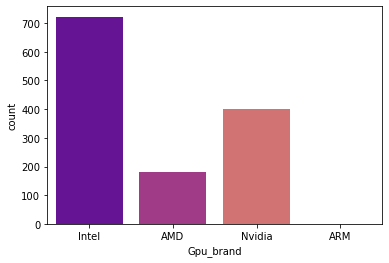

In [179]:
sns.countplot(df['Gpu_brand'], palette='plasma');

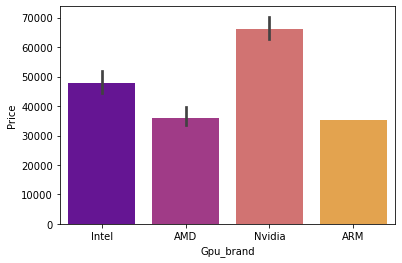

In [180]:
sns.barplot(df['Gpu_brand'], df['Price'], palette='plasma', estimator=np.median);

> We observe that laptops with Nvidia GPU's are expensive than other laptop which is common in general

In [181]:
# dropping gpu column 

df.drop(['Gpu'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram  OpSys  Weight        Price  TouchScreen  IPS  \
0   Apple  Ultrabook    8  macOS    1.37   71378.6832            0    1   
1   Apple  Ultrabook    8  macOS    1.34   47895.5232            0    0   
2      HP   Notebook    8  No OS    1.86   30636.0000            0    0   
3   Apple  Ultrabook   16  macOS    1.83  135195.3360            0    1   
4   Apple  Ultrabook    8  macOS    1.37   96095.8080            0    1   

          PPI       CPU_name  HDD  SSD Gpu_brand  
0  226.983002  Intel Core i5    0  128     Intel  
1  127.677940  Intel Core i5    0    0     Intel  
2  141.212006  Intel Core i5    0  256     Intel  
3  220.534622  Intel Core i7    0  512       AMD  
4  226.983002  Intel Core i5    0  256     Intel

##### Operating system analysis 

In [182]:
df['OpSys'].value_counts()

Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: OpSys, dtype: int64

**Note:**

No OS could be a option where missing value or OS is not mentioned in the data 

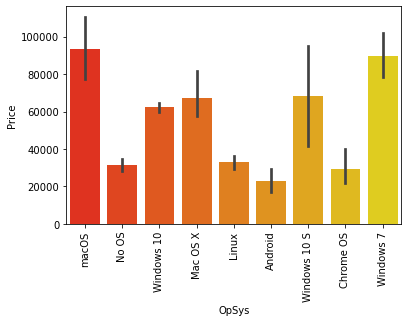

In [183]:
sns.barplot(df['OpSys'], df['Price'], palette='autumn')
plt.xticks(rotation='vertical')
plt.show()

> Laptops which have MacOS are expensive followed by Windows 7

In [184]:
def preprocess_ostypes(val):
    # clubbing all above categories into 3 common types windows, MacOs and other
    
    if val in ['Windows 7', 'Windows 10 s', 'Windows 10']:
        return "Windows"
    else:
        if val in ['macOS', 'Max OS X']:
            return "Mac"
        else:
            return "Other"
    
df['OpSys'] = df['OpSys'].apply(preprocess_ostypes)
df.sample(10)

Company            TypeName  Ram    OpSys  Weight        Price  \
659        Dell              Gaming   32  Windows    4.42  167691.8736   
1067       Dell  2 in 1 Convertible    8  Windows    1.62   42517.9728   
642      Lenovo           Ultrabook   16  Windows    1.14  130536.0000   
458   Microsoft           Ultrabook    8    Other    1.25   95850.7200   
411      Lenovo           Ultrabook    8  Windows    1.70  103523.0400   
868        Acer            Notebook    8  Windows    1.56   48058.5600   
1082     Lenovo  2 in 1 Convertible    4  Windows    0.69   34433.2656   
1033         HP            Notebook    8  Windows    1.95   63669.6000   
363          HP            Notebook    8  Windows    1.86   34045.9200   
462        Asus            Notebook    8  Windows    2.37   39906.7200   

      TouchScreen  IPS         PPI               CPU_name   HDD  SSD Gpu_brand  
659             0    1  254.671356          Intel Core i7  1000  512    Nvidia  
1067            1    0  165.632111          Intel Core i7     0  256     Intel  
642             0    1  157.350510          Intel Core i7     0  512     Intel  
458             1    0  200.842560          Intel Core i7     0  256     Intel  
411             0    1  209.800690          Intel Core i7     0  512    Nvidia  
868             0    1  157.350510          Intel Core i5     0  256     Intel  
1082            1    1  224.173813  Other Intel Processor     0    0     Intel  
1033            0    0  157.350510          Intel Core i5     0  256     Intel  
363             0    0  141.212006          Intel Core i5  1000    0     Intel  
462             0    0  141.212006          Intel Core i5  1000    0     Intel

In [185]:
df['OpSys'].value_counts()

Windows    1117
Other       173
Mac          13
Name: OpSys, dtype: int64

#### Weight feature analysis

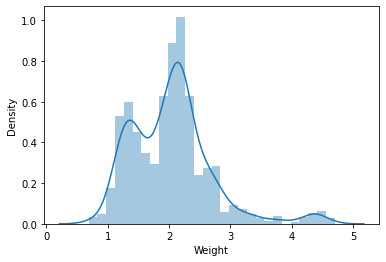

In [186]:
sns.distplot(df['Weight']);

* Laptop's weights is in range between 0.7 Kg and 5 Kgs
* Most of the laptops are in the range of 1.2 Kg and 2.7 kgs

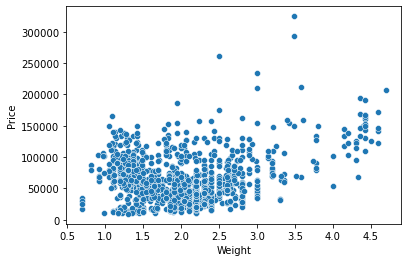

In [187]:
sns.scatterplot(df['Weight'], df['Price']);

#### Price analysis 

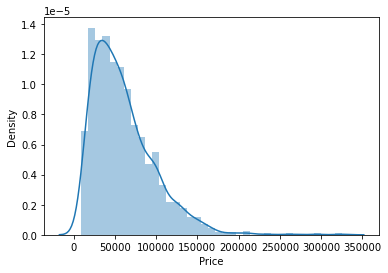

In [188]:
sns.distplot(df['Price']);

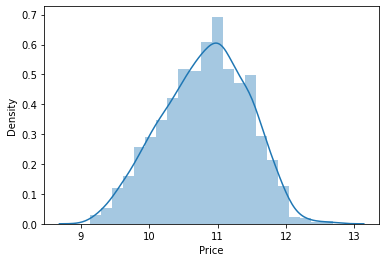

In [189]:
sns.distplot(np.log(df['Price']));

We applied logarithmic transformation to the Price feature, so it becomes gaussian distribution. It is well known that 
data which has normal distribution has good prediction performance on some models 

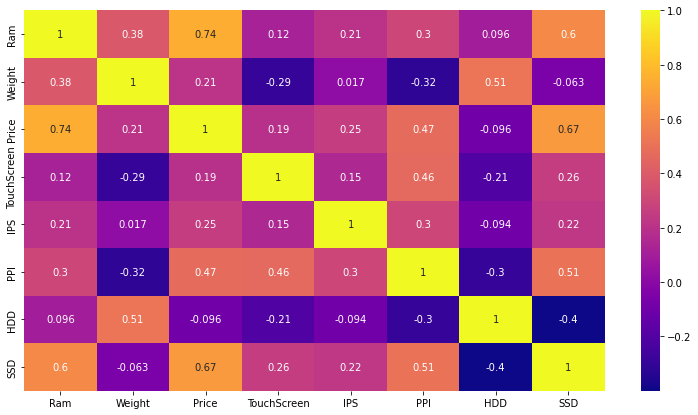

In [190]:
# let's see the correlation matrix now 

plt.figure(figsize=(13,7))
sns.heatmap(df.corr(), annot=True, cmap='plasma');

## Model Building 

Pre-processing of the data is completed except for encoding the categorical variables. 

Let's build a model and find a best one.

In [191]:
"""
Separating train and test set, also applying logarithm on target variable Price, to get back same 
value, it is possible to get using exp
"""

train = df.drop(['Price'], axis=1)
test = np.log(df['Price'])

In [192]:
test[:10]

0    11.175755
1    10.776777
2    10.329931
3    11.814476
4    11.473101
5     9.967026
6    11.644108
7    11.030615
8    11.285443
9    10.621952
Name: Price, dtype: float64

In [193]:
# splitting train and test set 

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.15, 
                                                   random_state=2)

X_train.shape, X_test.shape

((1107, 12), (196, 12))

**For Column Transformer, we will be applying transfroms on categorical data, also it requires an input of column
names or their index numbers. Here we will give index numbers as input.**

In [194]:
# to get index num of categorical columns

mapper = {i: val for i, val in enumerate(X_train.columns)}
mapper

{0: 'Company',
 1: 'TypeName',
 2: 'Ram',
 3: 'OpSys',
 4: 'Weight',
 5: 'TouchScreen',
 6: 'IPS',
 7: 'PPI',
 8: 'CPU_name',
 9: 'HDD',
 10: 'SSD',
 11: 'Gpu_brand'}

#### Linear Regression 

In [195]:
# applying one hot encoding to cat columns and building a model 

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))

R2 score:  0.8267257192814139
MAE score:  0.2079227645684716


In [196]:
np.exp(0.207)

1.2299825717807527

**Conclusions:**

* R2 score ndicates 82% of variability in Price is explained by all of the predictors.
* MAE score indicates on an average there is 0.20 error difference but it is in log scale, so after taking exp value,
  we confirm that only 1.22 Rs increase or decrease with respect to original price is observed

In [197]:
print(list(np.exp(y_pred[:5])))
print(list(np.exp(y_test[:5])))

[45508.18592042394, 16153.83628136605, 66612.32327538358, 83808.35741907064, 96359.57552560183]
[35964.000000000015, 13586.399999999996, 137995.2000000001, 72940.32000000005, 125207.99999999991]


#### Ridge regression 

In [198]:
# applying Ridge regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = Ridge(alpha=10)

ridge_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

ridge_pipe.fit(X_train, y_train)

y_pred = ridge_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))

R2 score:  0.8247008282606105
MAE score:  0.20945786390478374


#### Lasso regression 

In [199]:
# applying lasso regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = Lasso(alpha=0.001)

lasso_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

lasso_pipe.fit(X_train, y_train)

y_pred = lasso_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))

R2 score:  0.8255234293023515
MAE score:  0.21017467697084039


> Among all three linear models, based on R2 score and MAE score, Linear regression is the best model without any hyper parameter tuning.

#### Decision Tree 

In [200]:
# applying decision tree regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = DecisionTreeRegressor(max_depth=8)

tree_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

tree_pipe.fit(X_train, y_train)

y_pred = tree_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))

R2 score:  0.846219395539472
MAE score:  0.18651473562054857


#### Random Forest 

In [201]:
# applying Random forest regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = RandomForestRegressor(n_estimators = 100,
                             random_state = 3,
                             max_samples = 0.5,
                             max_features = 0.75,
                             max_depth = 15)

rf_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))

R2 score:  0.8903000379408615
MAE score:  0.15754480944947002


**The score has been improved a lot using random forest model which could be a best model so far** 

In [202]:
# we will store the model as pickel file 

import pickle

pickle.dump(df, open('processed_df.pkl', 'wb'))
pickle.dump(rf_pipe, open('rf_pipe.pkl', 'wb'))

### Hyper parameter tuning for random forest 

Since Random forest model have good perfomance metrics on the data, we will try tuning the hyper parameters to check
whether we could further improve the model 

In [203]:
# doing from the first for tuning 

index_list = [0, 1, 3, 8, 11]
transform_list = []

for key, value in mapper.items():
    if key in index_list:
        transform_list.append(value)
        
print(transform_list)

['Company', 'TypeName', 'OpSys', 'CPU_name', 'Gpu_brand']


In [204]:
X = pd.get_dummies(train, columns=transform_list, drop_first=True)
X.head()

Ram  Weight  TouchScreen  IPS         PPI  HDD  SSD  Company_Apple  \
0    8    1.37            0    1  226.983002    0  128              1   
1    8    1.34            0    0  127.677940    0    0              1   
2    8    1.86            0    0  141.212006    0  256              0   
3   16    1.83            0    1  220.534622    0  512              1   
4    8    1.37            0    1  226.983002    0  256              1   

   Company_Asus  Company_Chuwi  Company_Dell  Company_Fujitsu  Company_Google  \
0             0              0             0                0               0   
1             0              0             0                0               0   
2             0              0             0                0               0   
3             0              0             0                0               0   
4             0              0             0                0               0   

   Company_HP  Company_Huawei  Company_LG  Company_Lenovo  Company_MSI  \
0           0               0           0               0            0   
1           0               0           0               0            0   
2           1               0           0               0            0   
3           0               0           0               0            0   
4           0               0           0               0            0   

   Company_Mediacom  Company_Microsoft  Company_Razer  Company_Samsung  \
0                 0                  0              0                0   
1                 0                  0              0                0   
2                 0                  0              0                0   
3                 0                  0              0                0   
4                 0                  0              0                0   

   Company_Toshiba  Company_Vero  Company_Xiaomi  TypeName_Gaming  \
0                0             0               0                0   
1                0             0               0                0   
2                0             0               0                0   
3                0             0               0                0   
4                0             0               0                0   

   TypeName_Netbook  TypeName_Notebook  TypeName_Ultrabook  \
0                 0                  0                   1   
1                 0                  0                   1   
2                 0                  1                   0   
3                 0                  0                   1   
4                 0                  0                   1   

   TypeName_Workstation  OpSys_Other  OpSys_Windows  CPU_name_Intel Core i3  \
0                     0            0              0                       0   
1                     0            0              0                       0   
2                     0            1              0                       0   
3                     0            0              0                       0   
4                     0            0              0                       0   

   CPU_name_Intel Core i5  CPU_name_Intel Core i7  \
0                       1                       0   
1                       1                       0   
2                       1                       0   
3                       0                       1   
4                       1                       0   

   CPU_name_Other Intel Processor  Gpu_brand_ARM  Gpu_brand_Intel  \
0                               0              0                1   
1                               0              0                1   
2                               0              0                1   
3                               0              0                0   
4                               0              0                1   

   Gpu_brand_Nvidia  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, test, test_size=0.15, random_state=2)

X_train.shape, X_test.shape

((1107, 39), (196, 39))

In [206]:
reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train, y_train)
plt.figure(figsize=(16,9))
# tree.plot_tree(reg, filled=True, feature_names=X.columns)
# plt.show()

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

> Here we haven't given any parameters, so it will build a tree randomly which is not a optimized or a perfect one

In [207]:
# tuning one hyper parameter which is pruning 

path = reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [208]:
alpha_list = []

for alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    reg.fit(X_train, y_train)
    alpha_list.append(reg)

In [209]:
alpha_list

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.6688447271691604e-16, random_state=0),
 DecisionTreeRegressor(ccp_alpha=2.011984877609404e-12, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.2580740022970299e-11, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.395321076386135e-11, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.0848001649831398e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=2.6787889902877986e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=3.5173476497150033e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=4.906056121428737e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=6.249828124678966e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.1205648168876077e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=2.844239668638734e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=3.7189249395544767e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=3.851606298378122e-09, random_state=0),
 Dec

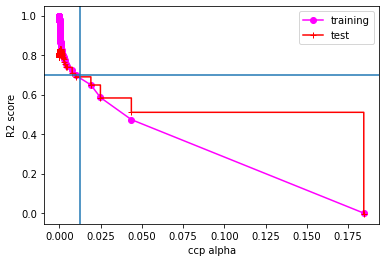

In [210]:
# plotting train score and test score for different trees with different ccp alpha values 

train_score = [reg.score(X_train, y_train) for reg in alpha_list]
test_score = [reg.score(X_test, y_test) for reg in alpha_list]

plt.xlabel("ccp alpha")
plt.ylabel("R2 score")

plt.plot(ccp_alphas, train_score, marker='o', color='magenta', label='training')
plt.plot(ccp_alphas, test_score, marker='+', color='red', label='test', drawstyle='steps-post')
plt.axvline(0.0125)
plt.axhline(0.7)
plt.legend()
plt.show()

>  Possible values of ccp alpha values which is in line with both training and test set lies between 0 and 0.025 that gives around 80% of R2 score.

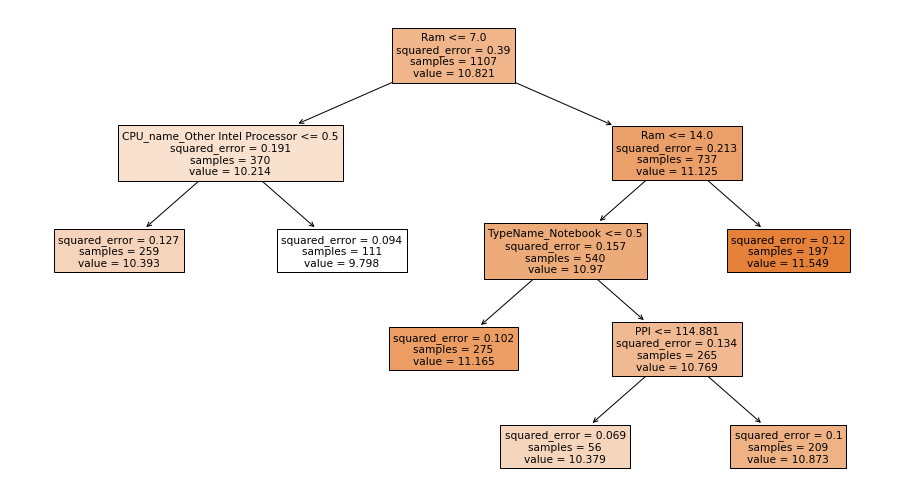

In [211]:
# plotting a decision tree with one of choosen value above

reg = DecisionTreeRegressor(random_state=0, ccp_alpha=0.0085)
reg.fit(X_train, y_train)
plt.figure(figsize=(16,9))
tree.plot_tree(reg, filled=True, feature_names=X_train.columns)
plt.show()

**Now the pruned decision tree is better and simple than previous overfitted tree. Here we just tuned only one hyperparameter**

In [212]:
# tuning multiple hyper paramaters 

params=  {
    
    'RandomForest':{
        'model' : RandomForestRegressor(),
        'params':{
            'n_estimators':[int(x) for x in np.linspace(100,1200,10)],
            'criterion':["mse", "mae"],
            'max_depth':[int(x) for x in np.linspace(1,30,5)],
            'max_features':['auto','sqrt','log2'],
            'ccp_alpha':[x for x in np.linspace(0.0025,0.0125,5)],
            'min_samples_split':[2,5,10,14],
            'min_samples_leaf':[2,5,10,14],
        }
    },
    'Decision Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'criterion':["mse", "mae"],
            'max_depth':[int(x) for x in np.linspace(1,30,5)],
            'max_features':['auto','sqrt','log2'],
            'ccp_alpha':[x for x in np.linspace(0.0025,0.0125,5)],
            'min_samples_split':[2,5,10,14],
            'min_samples_leaf':[2,5,10,14],
        }
    }
}

In [213]:
for i, j in params.items():
    print(i, j)

RandomForest {'model': RandomForestRegressor(), 'params': {'n_estimators': [100, 222, 344, 466, 588, 711, 833, 955, 1077, 1200], 'criterion': ['mse', 'mae'], 'max_depth': [1, 8, 15, 22, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'ccp_alpha': [0.0025, 0.005, 0.0075, 0.01, 0.0125], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [2, 5, 10, 14]}}
Decision Tree {'model': DecisionTreeRegressor(), 'params': {'criterion': ['mse', 'mae'], 'max_depth': [1, 8, 15, 22, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'ccp_alpha': [0.0025, 0.005, 0.0075, 0.01, 0.0125], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [2, 5, 10, 14]}}


In [214]:
# training the above params 

scores = []

for model_name, mp in params.items():
    clf = RandomizedSearchCV(mp['model'],
                            param_distributions=mp['params'], cv=5, n_iter=10, scoring='neg_mean_squared_error', verbose=2)
    clf.fit(X_train, y_train)
    scores.append(
    {'model_name': model_name,
    'best_score': clf.best_score_,
    'best_estimator': clf.best_estimator_
    })
    

    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ccp_alpha=0.01, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=14, min_samples_split=10, n_estimators=711; total time=   0.8s
[CV] END ccp_alpha=0.01, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=14, min_samples_split=10, n_estimators=711; total time=   0.8s
[CV] END ccp_alpha=0.01, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=14, min_samples_split=10, n_estimators=711; total time=   0.8s
[CV] END ccp_alpha=0.01, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=14, min_samples_split=10, n_estimators=711; total time=   0.8s
[CV] END ccp_alpha=0.01, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=14, min_samples_split=10, n_estimators=711; total time=   0.8s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=588; total time=   3.6s
[CV] END ccp_alpha=0.0125,

[CV] END ccp_alpha=0.0025, criterion=mae, max_depth=1, max_features=auto, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0025, criterion=mae, max_depth=1, max_features=auto, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.005, criterion=mae, max_depth=1, max_feat

In [215]:
scores

[{'model_name': 'RandomForest',
  'best_score': -0.07672742623991682,
  'best_estimator': RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=15,
                        min_samples_leaf=5, min_samples_split=5,
                        n_estimators=955)},
 {'model_name': 'Decision Tree',
  'best_score': -0.09768444746279117,
  'best_estimator': DecisionTreeRegressor(ccp_alpha=0.005, criterion='mae', max_depth=22,
                        max_features='auto', min_samples_leaf=14,
                        min_samples_split=10)}]

**The MSE score is negative as it negative error, it is considered as positive so the score of 0.08 is very good metric**

In [216]:
scores_df = pd.DataFrame(scores, columns=['model_name', 'best_score', 'best_estimator'])
scores_df

model_name  best_score  \
0   RandomForest   -0.076727   
1  Decision Tree   -0.097684   

                                      best_estimator  
0  (DecisionTreeRegressor(ccp_alpha=0.0025, max_d...  
1  DecisionTreeRegressor(ccp_alpha=0.005, criteri...

In [217]:
# building the above best model again 

rf = RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=15,
                        min_samples_leaf=10, min_samples_split=10,
                        n_estimators=955)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.r2_score(y_test, y_pred))

0.8097130181729647


> Our previous model gave 89% of R2 score which is better than tuned model, so we will choose the previous model for deployment

#### Prediction on whole dataset 

In [218]:
X.shape

(1303, 39)

In [219]:
final_model = RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=8,
                        max_features='log2', min_samples_leaf=2,
                        min_samples_split=5, n_estimators=344)
final_model.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=8,
                      max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=344)

In [220]:
predictions = np.array(final_model.predict(X))
predictions

array([11.14133756, 10.96428535, 10.71532248, ...,  9.83832454,
       10.46762804,  9.93143826])

In [221]:
# converting predicted values back to Rupees as we transformed them into log values

predictions = np.exp(predictions)

In [222]:
predictions

array([68963.83836593, 57773.49318028, 45040.73035717, ...,
       18738.29445668, 35158.7234395 , 20566.89994987])

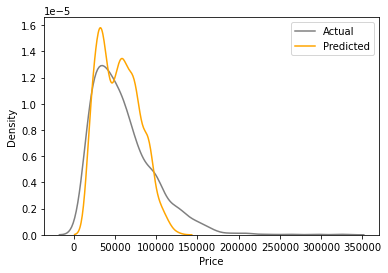

In [223]:
# plotting original and predicted price 

sns.distplot(df['Price'], color='grey', hist=False, label='Actual')
sns.distplot(predictions, color='orange', hist=False, label='Predicted')
plt.legend()
plt.show()

> Based on above comparison, we could see that predicted value graph stopped at 150000 INR, so it cannot be the best model 

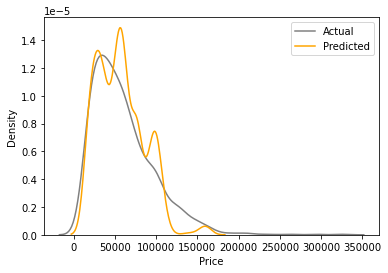

In [224]:
pred = np.exp(rf.predict(X))
sns.distplot(df['Price'], color='grey', hist=False, label='Actual')
sns.distplot(pred, color='orange', hist=False, label='Predicted')
plt.legend()
plt.show()

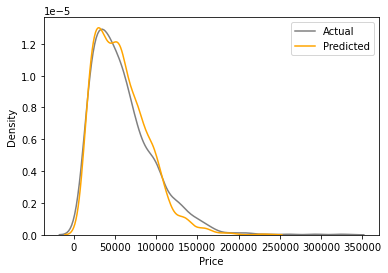

In [225]:
rf1 = RandomForestRegressor(n_estimators=100,
                           random_state=3,
                           max_samples=0.5,
                           max_features=0.75,
                           max_depth=15)
rf1.fit(X_train, y_train)
pred = np.exp(rf1.predict(X))
sns.distplot(df['Price'], color='grey', hist=False, label='Actual')
sns.distplot(pred, color='orange', hist=False, label='Predicted')
plt.legend()

plt.show()

In [226]:
rf1.score(X_test, y_test)

0.8858065931957776

In [227]:
rf1.score(X_train, y_train)

0.9518424960694459

In [228]:
# saving above model in pickle

file = open('laptop_predictor.pkl', 'wb')
pickle.dump(rf1, file)
file.close()